In [1]:
import json
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
from scipy.interpolate import interp1d

In [2]:
z = np.linspace(0, 10, 1000)
luminosity_distance = cosmo.luminosity_distance(z).value
luminosity_distance_to_z = interp1d(luminosity_distance, z, kind='cubic', fill_value='extrapolate')

In [3]:
# getting data from json
# all
with open("./unlensed_params_BBH_1M.json") as f:
    unlensed_params = json.load(f)
with open("./lensed_params_BBH_1M.json") as f:
    lensed_params = json.load(f)
# detectable
with open("./unlensed_params_detectable_BBH_1M.json") as f:
    unlensed_params_detectable = json.load(f)
with open("./lensed_params_detectable_BBH_1M.json") as f:
    lensed_params_detectable = json.load(f)

In [16]:
# getting data from json
# all
with open("./unlensed_params_conf8.json") as f:
    unlensed_params = json.load(f)
with open("./lensed_params_conf8.json") as f:
    lensed_params = json.load(f)

In [17]:
# unlensed events detectable
mass_1_unlensed = np.array(unlensed_params['mass_1'])
mass_2_unlensed = np.array(unlensed_params['mass_2'])

# chirp mass from m1 and m2
mc_unlensed = (mass_1_unlensed*mass_2_unlensed)**(3/5)/(mass_1_unlensed+mass_2_unlensed)**(1/5)

# redshifts
zs_unlensed = np.array(unlensed_params['zs'])

In [18]:
# selecting with SNRs>8
snrs = unlensed_params["opt_snr_net"]
snrs = np.array(snrs).flatten()
idx = snrs>8

mc_unlensed_ = mc_unlensed[idx]
zs_unlensed_ = zs_unlensed[idx]

In [25]:
mass_1_lensed = np.array(lensed_params['mass_1'])
mass_2_lensed = np.array(lensed_params['mass_2'])

# chirp mass from m1 and m2
mc_lensed = (mass_1_lensed*mass_2_lensed)**(3/5)/(mass_1_lensed+mass_2_lensed)**(1/5)
mc_lensed = np.array([mc_lensed,mc_lensed,mc_lensed,mc_lensed]).T

# redshifts
zs_lensed = np.array(lensed_params['zs'])

# to find the effective chirp mass
mu = np.abs(np.array(lensed_params['magnifications']))

# get the luminosity distance
dl = np.array(lensed_params['luminosity_distance'])
dl = np.array([dl,dl,dl,dl]).T

# find the effective luminosity distance
dl_eff = dl/np.sqrt(mu)
# find the effective redshift
zs_eff = luminosity_distance_to_z(dl_eff)

In [26]:
# selecting with SNRs>8
snrs = lensed_params["opt_snr_net"]
snrs = np.array(snrs).flatten()
idx2 = snrs>8

mc_lensed_ = mc_lensed.flatten()[idx2]
zs_eff_ = zs_eff.flatten()[idx2]

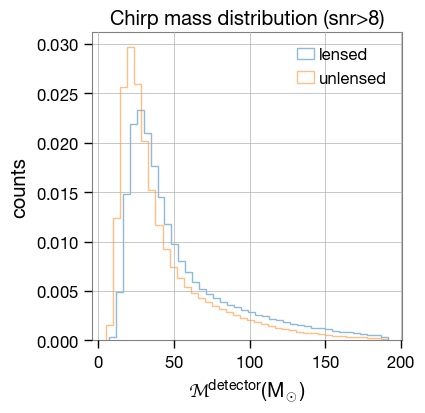

In [27]:
# mc distribution
plt.figure(figsize=(4,4))
plt.hist(mc_lensed_, bins=40, density=True, alpha=0.5, label="lensed", histtype='step')
# plt.hist(mc_lensed_source, bins=40, density=True, alpha=0.5, label="lensed (source)", histtype='step')
plt.hist(mc_unlensed_, bins=40, density=True, alpha=0.5, label="unlensed", histtype='step')
plt.xlabel(r"$\mathcal{M}^{detector} (M_\odot)$")
plt.ylabel("counts")
plt.title("Chirp mass distribution (snr>8)")
plt.legend()
plt.show()

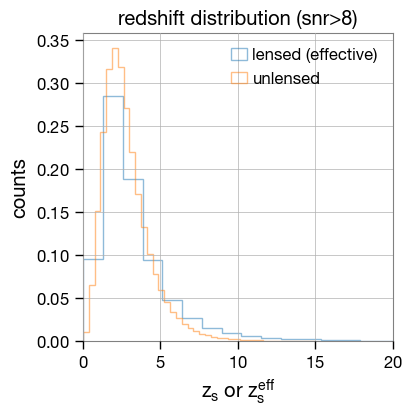

In [30]:
# zs distribution
plt.hist(zs_eff_, bins=40, density=True, alpha=0.5, label="lensed (effective)", histtype='step')
# plt.hist(zs_lensed, bins=40, density=True, alpha=0.5, label="lensed (source)", histtype='step')
plt.hist(zs_unlensed_, bins=40, density=True, alpha=0.5, label="unlensed", histtype='step')
plt.xlabel(r"$z_s$ or $z_s^{eff}$")
plt.ylabel("counts")
plt.title("redshift distribution (snr>8)")
plt.legend()
plt.xlim(0,20)
plt.show()

In [41]:
from scipy.stats import norm, gaussian_kde
from scipy.interpolate import interp1d
contour_levels=[0.10, 0.40, 0.68]
linestyles="-"
origin="upper"
alpha=0.6
extent=[0.001, 20, 5, 200]

In [42]:
# lensed case
x_array = zs_eff_
y_array = mc_lensed_
# applying cutt-off
idx = (
    (x_array > extent[0])
    & (x_array < extent[1])
    & (y_array > extent[2])
    & (y_array < extent[3])
)
xu = x_array[idx]
yu = y_array[idx]
# xu = x_array
# yu = y_array

xmin = extent[0]
xmax = extent[1]
ymin = extent[2]
ymax = extent[3]

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([xu, yu])
kernel = gaussian_kde(values)
ff = np.reshape(kernel(positions).T, xx.shape)

zsort = -np.sort(-ff.flatten())

cumz = np.cumsum(zsort) / np.sum(zsort)
spl = interp1d(cumz, zsort)

levels1 = []
for i in contour_levels:
    levels1.append(spl(i))
levels1 = np.array(levels1)[::-1]

In [43]:
# unlensed
x_array = zs_unlensed_
y_array = mc_unlensed_
# applying cutt-off
idx = (
    (x_array > extent[0])
    & (x_array < extent[1])
    & (y_array > extent[2])
    & (y_array < extent[3])
)
xu = x_array[idx]
yu = y_array[idx]
xu = x_array
yu = y_array

xmin = extent[0]
xmax = extent[1]
ymin = extent[2]
ymax = extent[3]

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([xu, yu])
kernel = gaussian_kde(values)
ff = np.reshape(kernel(positions).T, xx.shape)

zsort = -np.sort(-ff.flatten())

cumz = np.cumsum(zsort) / np.sum(zsort)
spl = interp1d(cumz, zsort)

levels2 = []
for i in contour_levels:
    levels2.append(spl(i))
levels2 = np.array(levels2)[::-1]

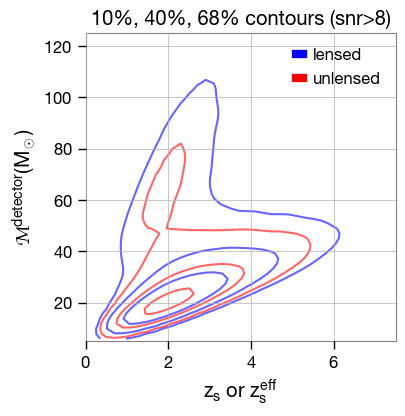

In [46]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.contour(
    np.rot90(ff),
    levels1,
    colors="blue",
    linestyles=linestyles,
    origin=origin,
    alpha=alpha,
    extent=extent,
    labels="lensed"
)
ax.contour(
    np.rot90(ff),
    levels2,
    colors="red",
    linestyles=linestyles,
    origin=origin,
    alpha=alpha,
    extent=extent,
)

# legend
custom_lines = [Line2D([0], [0], color='blue', lw=1.5),
                Line2D([0], [0], color='red', lw=1.5)]
plt.legend(custom_lines, ['lensed', 'unlensed'])

# ax.set_xlim(extent[0], extent[1])
# ax.set_ylim(extent[2], extent[3])
ax.set_xlim(0, 7.5)
ax.set_ylim(5, 125)
ax.set_ylabel(r"$\mathcal{M}^{detector} (M_\odot)$")
ax.set_xlabel(r"$z_s$ or $z_s^{eff}$")
ax.set_title("10%, 40%, 68% contours (snr>8)")

plt.show()

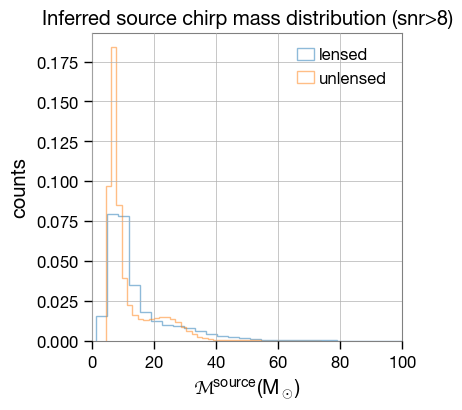

In [37]:
test_lensed = mc_lensed_/(1+zs_eff_)

test_unlensed = mc_unlensed_/(1+zs_unlensed_)

plt.hist(test_lensed, bins=40, density=True, alpha=0.5, label="lensed", histtype='step')
plt.hist(test_unlensed, bins=40, density=True, alpha=0.5, label="unlensed", histtype='step')
plt.xlim(0,100)
plt.xlabel(r"$\mathcal{M}^{source} (M_\odot)$")
plt.ylabel("counts")
plt.title("Inferred source chirp mass distribution (snr>8)")
plt.legend()
plt.show()

In [48]:
extent=[0.001, 7.5, 5, 50]

In [49]:
# lensed case
x_array = zs_eff_
y_array = test_lensed
# applying cutt-off
idx = (
    (x_array > extent[0])
    & (x_array < extent[1])
    & (y_array > extent[2])
    & (y_array < extent[3])
)
xu = x_array[idx]
yu = y_array[idx]
# xu = x_array
# yu = y_array

xmin = extent[0]
xmax = extent[1]
ymin = extent[2]
ymax = extent[3]

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([xu, yu])
kernel = gaussian_kde(values)
ff = np.reshape(kernel(positions).T, xx.shape)

zsort = -np.sort(-ff.flatten())

cumz = np.cumsum(zsort) / np.sum(zsort)
spl = interp1d(cumz, zsort)

levels1 = []
for i in contour_levels:
    levels1.append(spl(i))
levels1 = np.array(levels1)[::-1]

In [50]:
# unlensed
x_array = zs_unlensed_
y_array = test_unlensed
# applying cutt-off
idx = (
    (x_array > extent[0])
    & (x_array < extent[1])
    & (y_array > extent[2])
    & (y_array < extent[3])
)
xu = x_array[idx]
yu = y_array[idx]
# xu = x_array
# yu = y_array

xmin = extent[0]
xmax = extent[1]
ymin = extent[2]
ymax = extent[3]

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([xu, yu])
kernel = gaussian_kde(values)
ff = np.reshape(kernel(positions).T, xx.shape)

zsort = -np.sort(-ff.flatten())

cumz = np.cumsum(zsort) / np.sum(zsort)
spl = interp1d(cumz, zsort)

levels2 = []
for i in contour_levels:
    levels2.append(spl(i))
levels2 = np.array(levels2)[::-1]

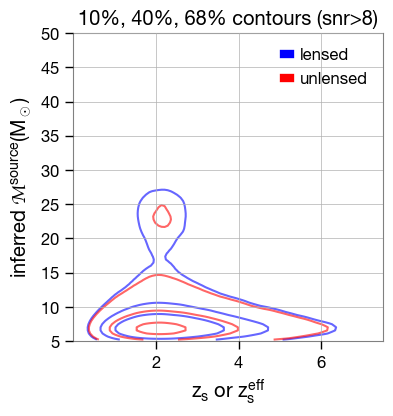

In [51]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.contour(
    np.rot90(ff),
    levels1,
    colors="blue",
    linestyles=linestyles,
    origin=origin,
    alpha=alpha,
    extent=extent,
    labels="lensed"
)
ax.contour(
    np.rot90(ff),
    levels2,
    colors="red",
    linestyles=linestyles,
    origin=origin,
    alpha=alpha,
    extent=extent,
)

# legend
custom_lines = [Line2D([0], [0], color='blue', lw=1.5),
                Line2D([0], [0], color='red', lw=1.5)]
plt.legend(custom_lines, ['lensed', 'unlensed'])

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_ylabel(r"inferred $\mathcal{M}^{source} (M_\odot)$")
ax.set_xlabel(r"$z_s$ or $z_s^{eff}$")
ax.set_title("10%, 40%, 68% contours (snr>8)")

plt.show()